In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries 

from alpha_vantage.timeseries import TimeSeries 

import pandas as pd


from tqdm.notebook import tqdm
from tqdm.autonotebook import trange
import pickle
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
from multiprocessing.pool import ThreadPool
import time


import sklearn
from sklearn.preprocessing import StandardScaler

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


/tmp/ipykernel_98802/1668313209.py:19: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


In [2]:
# set all configures in one dictonary
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu') 
device
conf_my = { "train": { "device":device,
                    "batch_size": 64,
                    "epoch_amount": 100,
                    "lr": 0.01,
                     "train_period": 20,
                     "predict_period": 2},
        
           "train_test_split": 0.8,
        "API_key": "B4BZJ2ZA0MGDODUA"
       }


4.0
28.000028000028
56.000056000056
112.000112000112
        date     price  split
0 1999-11-01  0.693035    1.0
1 1999-11-02  0.716517    1.0
2 1999-11-03  0.727678    1.0
1.0


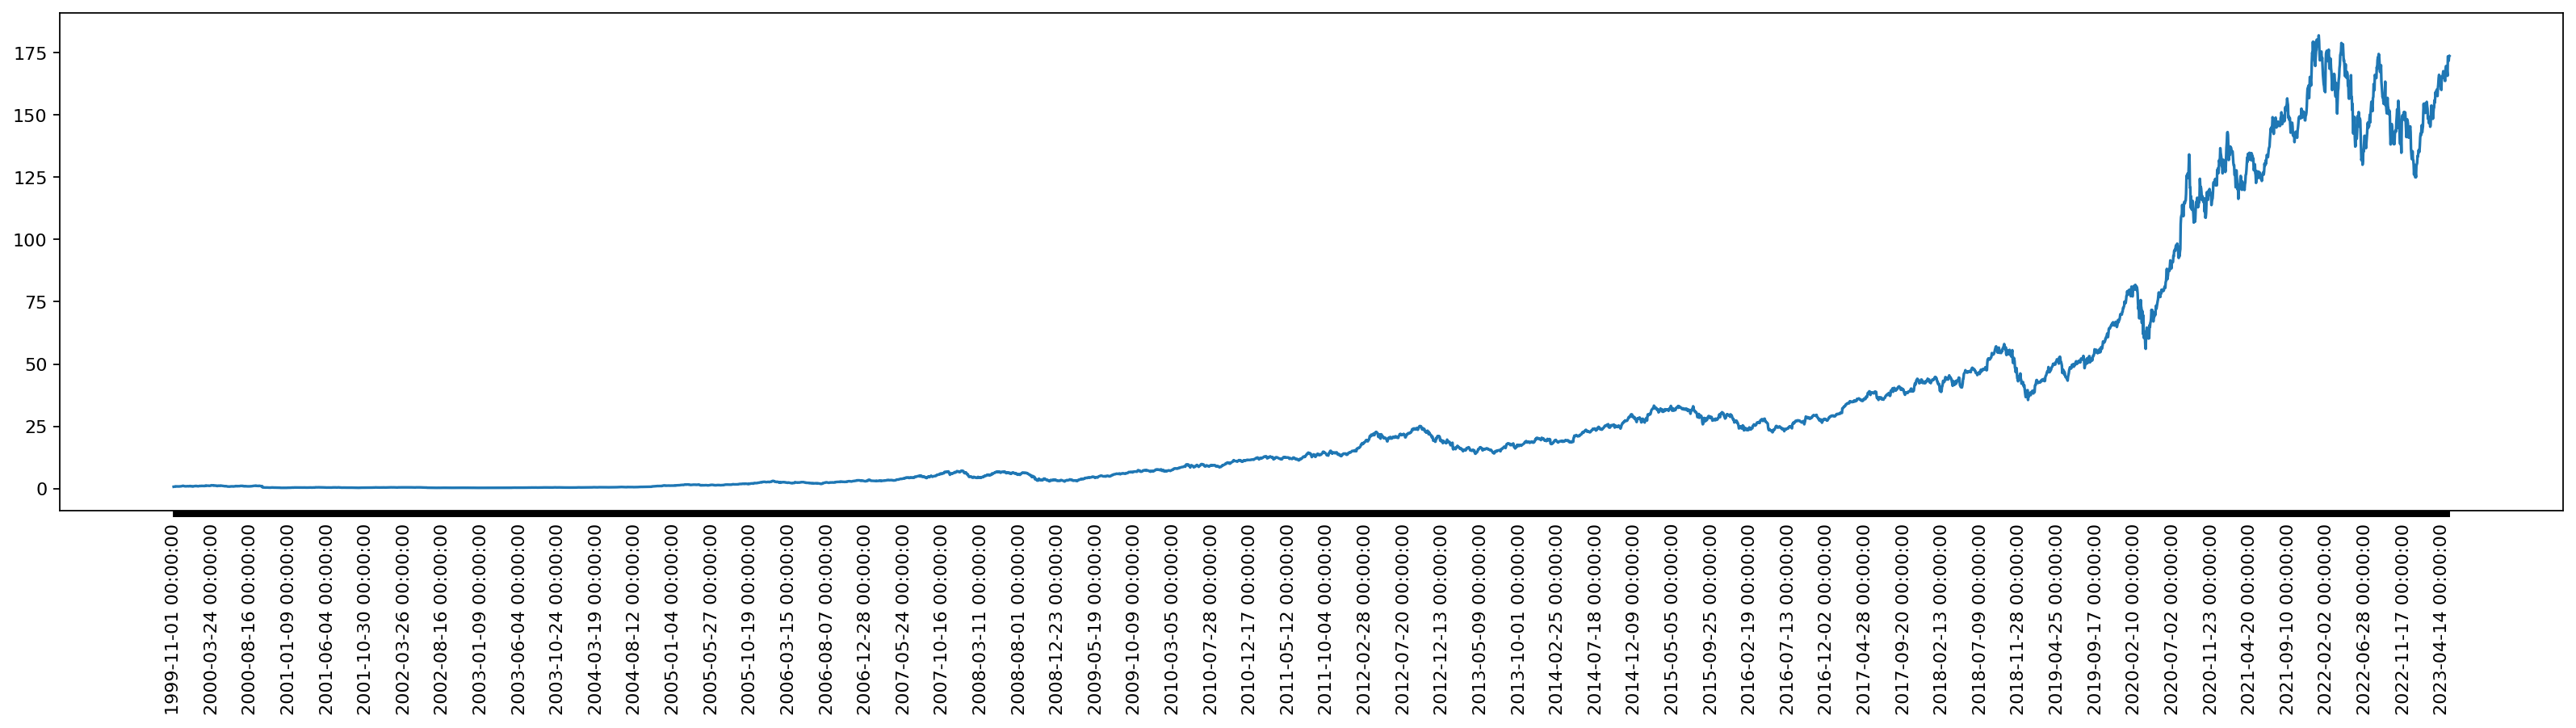

In [3]:
# =====================================
# =========download data (my version)============================
# =====================================


ts1 = TimeSeries(key=conf_my["API_key"], output_format='pandas')
data1, meta_data1 = ts1.get_daily_adjusted(symbol='AAPL', outputsize='full')

data_date1 = [date for date in data1.keys()]
data_date1.reverse()

# I have date indexes, I want to make from this indexes to columns
data1.reset_index(inplace=True)

#print(data1["8. split coefficient"].unque())
data1 = data1.drop(columns=['1. open', '2. high', '3. low', '5. adjusted close', '6. volume', '7. dividend amount'])
data1 = data1.rename(columns = {"date":"date", "4. close": "price", "8. split coefficient": "split"})

k = 1
bool_list = data1["split"]!= 1.
divination = np.ones(len(bool_list))
for i in range(len(data1["split"])):
    el = bool_list[i]
    if el == False:
        divination[i] /= k
        continue
    else:
        k *= data1["split"][i]
        print(k)
        divination[i] /= k

divination = pd.DataFrame(divination)

data1["price"] *= divination[divination.keys()[0]]
data1["price"] *= data1["split"]
data1 = data1.iloc[::-1]
data1 = data1.set_index(np.arange(0, len(data1["price"])))
#data1["date"] = data1["date"].iloc[::-1]
print(data1.head(3))
fig = plt.figure(figsize=(25, 5), dpi=160)
plt.plot(np.arange(0, len(data1["price"])), data1["price"], "-")

xticks_value = [data1["date"][i] if i %100 == 0 else None for i in range(len(data1["price"]))  ]
xtv = np.arange(0,len(xticks_value))
plt.xticks(xtv, xticks_value, rotation='vertical')
print(data1["split"][0])

In [7]:
data1 = data1.set_index(np.arange(0, len(data1["price"])))
print(type(data_date1))
data1.head(3)


<class 'pandas.core.series.Series'>


,date,price,split
0,1999-11-01,0.693035,1.0
1,1999-11-02,0.716517,1.0
2,1999-11-03,0.727678,1.0



## Data preparing

in this cell I performed data normalization and test division of the train dataset

1. I made the data normalization by this equation:

$$\mathbf{x_i}^{\text{new}} = \frac{\mathbf{x_i} - \mu_i}{\sigma_i}$$

2. I performed divination of the train dataset by **Rolling Window** method

In this project i will train the model to prection ***n*** days price based on the past ***20*** days. 






In [5]:
# ======================================
# ================normalization======================
# ======================================

def normalization(x: pd.DataFrame):
    mu = x.mean()
    std = x.std()
    x_normalization = (x - mu) / std
    return x_normalization

data_norm1 = normalization(data1["price"])
data_date1 = data1["date"].copy()



In [6]:
# ======================================
# ================test train======================
# ======================================

window_size = 30
step = 7

# Разбиваем данные на обучающую и тестовую выборки
train_data = data1[:-step]
test_data = data1[-step:]

# Генерируем временные окна
train_windows = []
for i in range(len(train_data) - window_size):
    train_windows.append(train_data[i:i+window_size])
    
test_windows = []
for i in range(len(test_data) - window_size):
    test_windows.append(test_data[i:i+window_size])

# Преобразуем данные в тензоры PyTorch
train_tensors = [torch.tensor(window) for window in train_windows]
test_tensors = [torch.tensor(window) for window in test_windows]

# Создаем DataLoader для обучающих и тестовых данных
train_loader = DataLoader(train_tensors, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_tensors, batch_size=batch_size, shuffle=False)
    

ValueError: could not determine the shape of object type 'DataFrame'

In [ ]:





config = {
    "alpha_vantage": {
        "key": "JS1SVUP23PNY92G7", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
        "symbol": "AAPL",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}





def download_data(config, plot=False):
    # get the data from alpha vantage

    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()
    print(data_date)
    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points:", num_data_points, display_date_range)

    if plot:
        fig = plt.figure(figsize=(25, 5), dpi=160)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
        plt.show()

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config, plot=config["plots"]["show_plots"])
































In [8]:

print(data_date1)

0      1999-11-01
1      1999-11-02
2      1999-11-03
3      1999-11-04
4      1999-11-05
          ...    
5915   2023-05-05
5916   2023-05-08
5917   2023-05-09
5918   2023-05-10
5919   2023-05-11
Name: date, Length: 5920, dtype: datetime64[ns]
